In [2]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt

# Definition of data

In [3]:
generation_costs = np.array([15, 20, 15, 20, 30, 25.])
capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

In [4]:
rt = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Plotting Functions

In [5]:
def plot_analysis(rt, git, dt, generation_costs):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plt.fill_between(list(range(1,25)), 0, rt, label='Renewables')
    for i in range(6):
        plt.fill_between(list(range(1,25)), rt+git[:i,:].sum(axis=0), rt+git[:i+1,:].sum(axis=0), label=f'Generator {i+1}')
    plt.plot(list(range(1,25)),dt, color='black', label='Demand')
    plt.legend(loc='upper left')
    plt.title('Total Production')
    plt.subplot(1,3,2)
    for i in range(6):
        plt.plot(list(range(1,25)), git[i,:], label=f'Generator {i+1}', color=f'C{i+1}')
    plt.legend(loc='upper left')
    plt.title('Individual Production')
    plt.subplot(1,3,3)
    for i in range(6):
        plt.bar([i], [generation_costs[i]], label=f'Generator {i}', color=f'C{i+1}')
    plt.legend(loc='lower right')
    plt.title('Generation Cost');
    
def plot_battery(charge, charging, discharging):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    plt.plot(charge)
    plt.title('Battery Charge')

    plt.subplot(1,2,2)
    plt.plot(charging, label='Charging')
    plt.plot(discharging, label='Discharging')
    plt.title('Battery Charging');

# Question 1.1

In [6]:
g = cp.Variable((6,24))
objective = cp.Minimize(cp.sum(g.T @ generation_costs))
constraints = [
    dt == rt + cp.sum(g, axis=0),
    g[:, 1:] - g[:, :-1] <= ramp_up_rate.reshape((-1,1)),
    g[:, 1:] - g[:, :-1] >= -ramp_down_rate.reshape((-1,1)),
    g>=0,
    g<=capacity.reshape((-1,1)),
]

problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.GLPK, verbose=False)

10158.5

In [7]:
print(f'The objective Value is {round(objective.value,2)}')

The objective Value is 10158.5


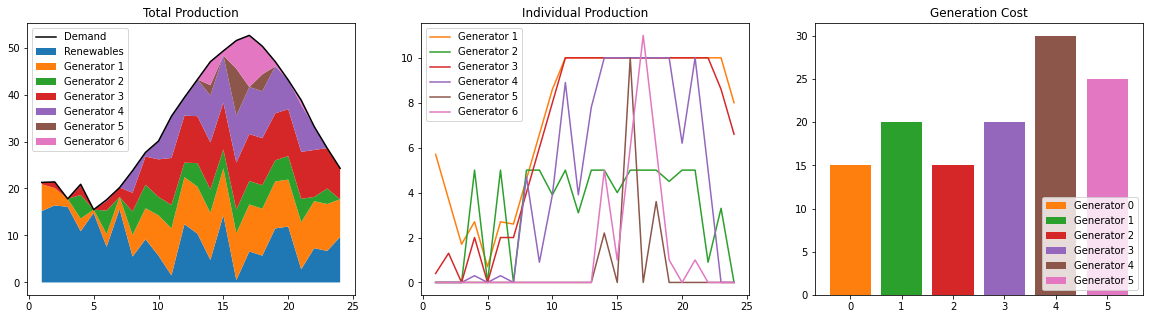

In [8]:
plot_analysis(rt, g.value, dt, generation_costs)

# Question 1.2

In [20]:
nu_d = 0.92
nu_c = 0.95
S_bar = 20

In [21]:
g = cp.Variable((6,24))
S = cp.Variable((24,))
b_c = cp.Variable((24,))
b_d = cp.Variable((24,))



objective = cp.Minimize(cp.sum(g.T @ generation_costs))
constraints = [
    dt == rt + cp.sum(g, axis=0) + nu_d*b_d - b_c,
    g[:, 1:] - g[:, :-1] <= ramp_up_rate.reshape((-1,1)),
    g[:, 1:] - g[:, :-1] >= -ramp_down_rate.reshape((-1,1)),
    g>=0,
    g<=capacity.reshape((-1,1)),
    S <= S_bar,
    S[1:] == S[:-1] + b_c[:-1]*nu_c - b_d[:-1],
    S[0] ==0,
    0 == S[-1] + b_c[-1]*nu_c - b_d[-1],
    b_c>=0,
    b_d>=0,
    S>=0
]

problem = cp.Problem(objective, constraints)
problem.solve(solver = cp.GLPK, verbose=False)

9777.672768878718

In [22]:
print(f'The objective Value is {round(objective.value,2)}')

The objective Value is 9777.67


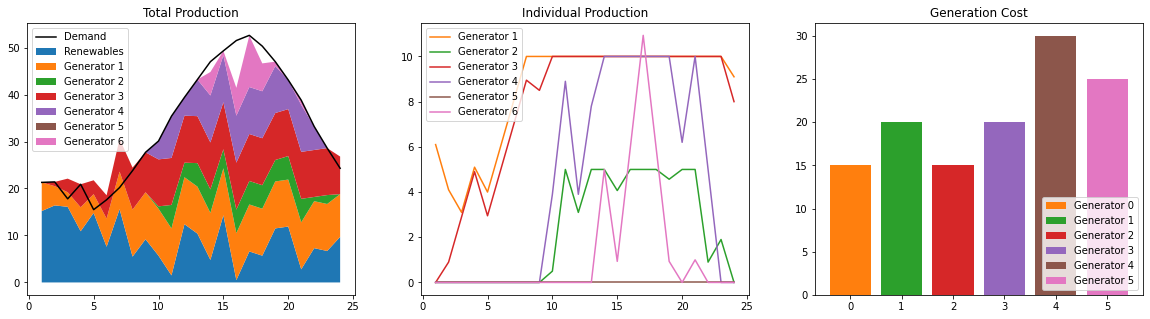

In [11]:
plot_analysis(rt, g.value, dt, generation_costs)

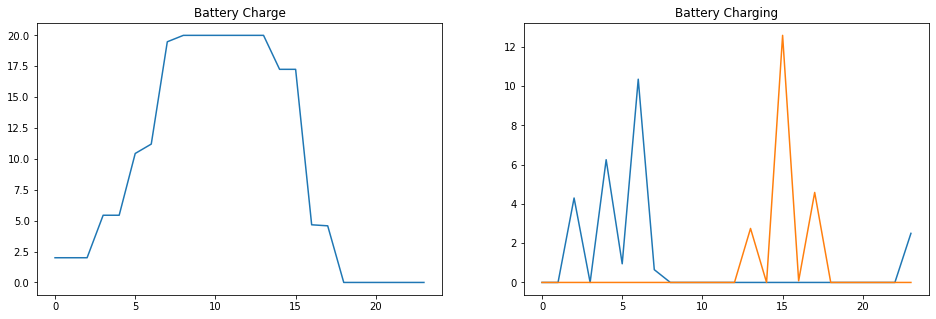

In [12]:
plot_battery(S.value, b_c.value, b_d.value)